# Práctica 2: Distribución de Poisson con Eventos Raros

## Objetivos
1.  Medir los conteos de eventos raros (doble-seis) por intervalos.
2.  Estimar el parámetro $\lambda$ de la distribución de Poisson.
3.  Verificar el ajuste de los datos a una distribución de Poisson mediante la prueba Chi-cuadrado.
4.  Contrastar la propiedad de la distribución de Poisson donde la media y la varianza son iguales ($E[Y] = \text{Var}(Y) = \lambda$).

## Definición del Experimento
Se analiza el número de veces que se obtiene un "doble-seis" al lanzar dos dados. Este es un evento raro, y el número de ocurrencias en un intervalo fijo sigue una distribución de Poisson.

$Y \sim \text{Poisson}(\lambda)$

Donde:
- $Y$ es el número de doble-seis contados en un intervalo.
- $\lambda$ es el número promedio de ocurrencias (doble-seis) por intervalo.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson, chi2

# Cargar los datos
df = pd.read_csv('datos_practica2.csv')

# Mostrar los primeros 5 intervalos
df.head()

,intervalo,lanzamientos_en_minuto,doble_seis_contados
0,1,55,1
1,2,48,2
2,3,59,1
3,4,52,0
4,5,60,2


## Estimación del Parámetro $\lambda$

El parámetro $\lambda$ de la distribución de Poisson representa la tasa media de ocurrencia de un evento en un intervalo específico. El mejor estimador para $\lambda$ es la media muestral de los conteos observados.

**Estimador de $\lambda$:**
$\hat{\lambda} = \bar{y} = \frac{1}{N} \sum_{i=1}^{N} y_i$

Donde:
- $N$ es el número total de intervalos.
- $y_i$ es el número de eventos (doble-seis) contados en el intervalo $i$.

In [3]:
# Extraer la columna de conteos de 'doble_seis_contados'
y_values = df['doble_seis_contados']

# Estimar lambda (λ)
lambda_estimado = np.mean(y_values)

# Calcular la varianza muestral
varianza_muestral = np.var(y_values, ddof=1)  # ddof=1 para varianza insesgada

print(f"Estimador de λ (λ̂): {lambda_estimado:.4f}")
print(f"Varianza muestral (s²): {varianza_muestral:.4f}")

Estimador de λ (λ̂): 1.2500
Varianza muestral (s²): 0.4079


## Comparación de Frecuencias Observadas y Esperadas

Para evaluar si los datos se ajustan a una distribución de Poisson, comparamos las frecuencias observadas de los conteos con las frecuencias esperadas teóricas.

La probabilidad de observar exactamente $k$ eventos en un intervalo está dada por la **función de masa de probabilidad (PMF)** de la distribución de Poisson:

$P(Y=k) = \frac{e^{-\lambda} \lambda^k}{k!}$

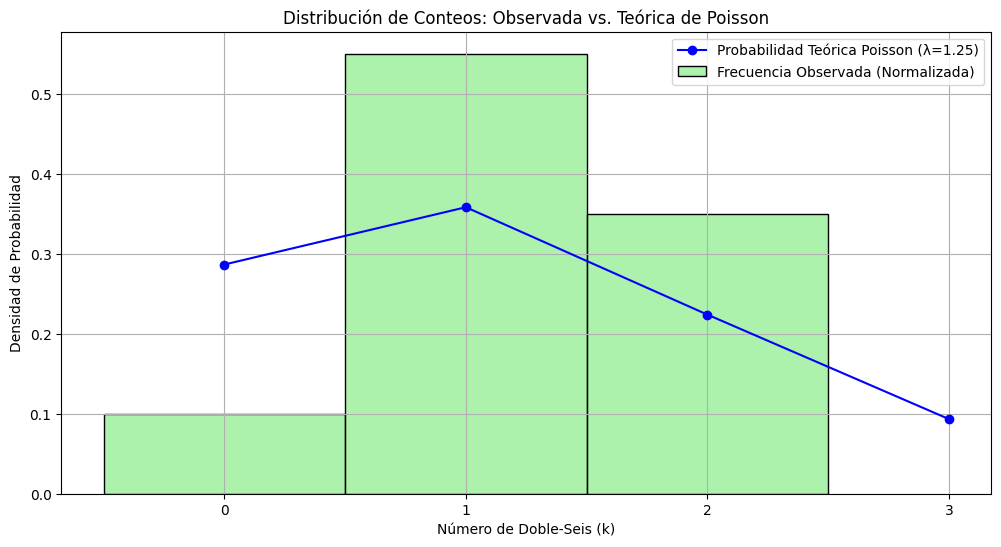

In [4]:
# Frecuencias observadas
frecuencias_observadas = y_values.value_counts().sort_index()

# Rango de posibles conteos
k_range = np.arange(0, y_values.max() + 2)

# Probabilidades teóricas de Poisson
probabilidades_teoricas = poisson.pmf(k_range, lambda_estimado)

# Gráfico de la distribución de frecuencias observadas
plt.figure(figsize=(12, 6))
sns.histplot(y_values, bins=np.arange(y_values.min(), y_values.max() + 2) - 0.5, stat='density', discrete=True, label='Frecuencia Observada (Normalizada)', color='lightgreen')

# Gráfico de la distribución de probabilidad teórica
plt.plot(k_range, probabilidades_teoricas, 'bo-', label=f'Probabilidad Teórica Poisson (λ={lambda_estimado:.2f})')

plt.title('Distribución de Conteos: Observada vs. Teórica de Poisson')
plt.xlabel('Número de Doble-Seis (k)')
plt.ylabel('Densidad de Probabilidad')
plt.xticks(k_range)
plt.legend()
plt.grid(True)
plt.show()

## Prueba de Bondad de Ajuste Chi-cuadrado ($\chi^2$)

Para verificar formalmente si los datos observados se ajustan a la distribución de Poisson, utilizamos la prueba de Chi-cuadrado.

El estadístico de prueba se calcula como:
$\chi^2 = \sum_{i=1}^{m} \frac{(O_i - E_i)^2}{E_i}$

Donde:
- $O_i$ es la frecuencia observada para la categoría $i$.
- $E_i$ es la frecuencia esperada para la categoría $i$, calculada como $N \times P(Y=k_i)$.
- $m$ es el número de categorías.

**Hipótesis:**
- $H_0$: Los datos siguen una distribución de Poisson con $\lambda = \hat{\lambda}$.
- $H_1$: Los datos no siguen dicha distribución.

Se comparará el valor de $\chi^2$ calculado con un valor crítico de la distribución Chi-cuadrado con $m-1-1 = m-2$ grados de libertad (se resta 1 adicional porque estimamos $\lambda$ a partir de los datos) y un nivel de significancia $\alpha$.

In [5]:
# Número total de intervalos
N = len(df)

# Crear tabla de frecuencias
frec_observada = y_values.value_counts().sort_index()
df_frec = pd.DataFrame({'observada': frec_observada})

# Calcular frecuencias esperadas
df_frec['prob_teorica'] = poisson.pmf(df_frec.index, lambda_estimado)
df_frec['esperada'] = df_frec['prob_teorica'] * N

# Agrupar categorías con frecuencia esperada < 5
umbral = 5
if (df_frec['esperada'] < umbral).any():
    # Agrupar las categorías de cola
    cola = df_frec[df_frec['esperada'] < umbral]
    if not cola.empty:
        cola_observada = cola['observada'].sum()
        cola_esperada = cola['esperada'].sum()
        
        # Eliminar filas de la cola
        df_frec = df_frec[df_frec['esperada'] >= umbral]
        
        # Añadir la categoría agrupada
        df_frec.loc['>= ' + str(cola.index.min())] = [cola_observada, np.nan, cola_esperada]

# Extraer frecuencias finales para la prueba
O = df_frec['observada'].values
E = df_frec['esperada'].values

# Calcular el estadístico Chi-cuadrado
chi2_calculado = np.sum((O - E)**2 / E)

# Grados de libertad
# m (número de categorías) - 1 (por el total) - 1 (por estimar lambda)
grados_libertad = len(O) - 2

# Nivel de significancia
alpha = 0.05

# Valor crítico de Chi-cuadrado
chi2_critico = chi2.ppf(1 - alpha, grados_libertad)

# p-valor
p_valor = 1 - chi2.cdf(chi2_calculado, grados_libertad)

print("Tabla de Frecuencias para Prueba Chi-cuadrado:")
print(df_frec)
print("\n--- Resultados de la Prueba Chi-cuadrado ---")
print(f"Estadístico Chi-cuadrado calculado (χ²): {chi2_calculado:.4f}")
print(f"Grados de libertad: {grados_libertad}")
print(f"Valor crítico de Chi-cuadrado (α=0.05): {chi2_critico:.4f}")
print(f"p-valor: {p_valor:.4f}")

# Conclusión
if chi2_calculado > chi2_critico:
    print("\nConclusión: Se rechaza la hipótesis nula (H₀).")
    print(f"Los datos no parecen seguir una distribución de Poisson con λ={lambda_estimado:.2f}.")
else:
    print("\nConclusión: No se puede rechazar la hipótesis nula (H₀).")
    print(f"Los datos son consistentes con una distribución de Poisson con λ={lambda_estimado:.2f}.")

Tabla de Frecuencias para Prueba Chi-cuadrado:
                     observada  prob_teorica  esperada
doble_seis_contados                                   
0                          2.0      0.286505  5.730096
1                         11.0      0.358131  7.162620
>= 2                       7.0           NaN  4.476637

--- Resultados de la Prueba Chi-cuadrado ---
Estadístico Chi-cuadrado calculado (χ²): 5.9064
Grados de libertad: 1
Valor crítico de Chi-cuadrado (α=0.05): 3.8415
p-valor: 0.0151

Conclusión: Se rechaza la hipótesis nula (H₀).
Los datos no parecen seguir una distribución de Poisson con λ=1.25.
